In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
plt.rcParams["figure.figsize"] = (25,10)

plt.rcParams.update({'font.size': 22})

colors='bgrykcm'
symbol='*-+^'

In [2]:
import Numerov
import utils
import Hartree_XC
import numpy as np
import Atomic_Like_Potential as ALP
from Predictor_Corrector_RK4 import predictor_corrector_radial_shcrodinger_integrator
from Atomic_Like_Potential import V_eff
from Radial_Eigenfunction import Radial_Eigenfunction

In [3]:
def predictor_corrector_radial_shcrodinger_integrator_exponential_grid(grid, w10,w20, kwargs):
    E= kwargs['E']
    #h= kwargs['delta_x']
    #h_arra= np.array(grid[1:]) - np.array(grid[:-1])
    h_arra= np.array(grid[:-1]) - np.array(grid[1:])
    Z= kwargs['Z']
    l= kwargs['l']

    w1=[w10]
    w2=[w20]

    for i,ri in enumerate(grid[:3]):
        h= h_arra[i]
        k1=4*[0.0]
        k2=4*[0.0]
        vj0= V_eff(ri,Z,l,E)#ALP.V_coulomb(ri, Z) + ALP.V_angular(ri, l)
        vj12= V_eff(ri + 0.5*h,Z,l,E)#ALP.V_coulomb(ri + 0.5*h, Z) + ALP.V_angular(ri + 0.5*h, l)
        vj3= V_eff(ri + h,Z,l,E)#ALP.V_coulomb(ri + h, Z) + ALP.V_angular(ri + h, l)
        for j in range(4):
            #k1[j]=h*(w2[i] + 0.5*k2[j-1])
            if j == 0:
                k1[j]=h*(w2[i])
                k2[j]= h*vj0*w1[i]
            elif j == 1 or j == 2:
                k1[j]=h*(w2[i] + 0.5*k2[j-1])
                k2[j]= h*2.0*vj12*(w1[i] + 0.5*k1[j-1])
            elif j == 3:
                k1[j]=h*(w2[i] + k2[j-1])
                k2[j]= h*2.0*vj3*(w1[i] + k1[j-1])
        w1.append( w1[i] + (1.0/6.0)*(k1[0] + 2.0*k1[1] + 2.0*k1[2] + k1[3]))
        w2.append( w2[i] + (1.0/6.0)*(k2[0] + 2.0*k2[1] + 2.0*k2[2] + k2[3]))

    for i in range(4,len(grid)):
        h= h_arra[i-1]
        ri= grid[i]
        r1= grid[i-1]
        r2= grid[i-2]
        r3= grid[i-3]
        r4= grid[i-4]
        wp1= w1[i-1] + h*(55.0*w2[i-1] - 59.0*w2[i-2]
                       +37.0*w2[i-3] - 9.0*w2[i-4])/24.0

        wp2= w2[i-1] + h*(55.0*V_eff(r1,Z,l,E)*w1[i-1] - 59.0*V_eff(r2,Z,l,E)*w1[i-2]
                       +37.0*V_eff(r3,Z,l,E)*w1[i-3] - 9.0*V_eff(r4,Z,l,E)*w1[i-4])/24.0

        wc1= w1[i-1] + h*(9.0*wp2 + 19.0*w2[i-1]
                       -5.0*w2[i-2] + w2[i-3])/24.0

        wc2= w2[i-1] + h*(9.0*V_eff(ri,Z,l,E)*wc1 + 19.0*V_eff(r1,Z,l,E)*w1[i-1]
                       -5.0*V_eff(r2,Z,l,E)*w1[i-2] + V_eff(r3,Z,l,E)*w1[i-3])/24.0

        w1.append(wc1)
        w2.append(wc2)
    return w1

def normlize_function_exponential_grid(expo_grid, function):
    h_arra= np.array(expo_grid[:-1]) - np.array(expo_grid[1:])

    func_sqrt= np.array(function)**2.
    I= np.sum((h_arra/2.0)*(func_sqrt[:-1]+func_sqrt[1:]))
    I=I**0.5
    func_norm= function/I
    return func_norm

In [4]:
r_max=10.0
grid_points=2000
delta=0.0025
rp= utils.get_rp(r_max, grid_points, delta)

exp_grid= utils.get_exponential_grid(delta=delta, rp=rp, grid_points=grid_points)
h_temp= exp_grid[-1] - exp_grid[-2]
for i in range(0, 4):
    exp_grid.append(exp_grid[-1] + h_temp)
exp_grid= list(np.array(exp_grid) + 1.0e-12)
#j_arra= [*range(len(exp_grid))]
exp_grid.reverse()
#j_arra.reverse()

In [5]:
kwargs={'l':0, 'Z':1.0, 'E':-0.5,}
u_hydr= utils.U_Hydrogen(exp_grid)
u_hydr_norm= normlize_function_exponential_grid(exp_grid, u_hydr)
w10= u_hydr[0]
w20= (u_hydr[1] - u_hydr[0])/(u_hydr[1] - u_hydr[0])
#w10= 1.0e-7#u_hydr[0]
#w20= (1.2e-8 - w10)//kwargs['delta_x']#(u_hydr[1] - u_hydr[0])/kwargs['delta_x']

In [6]:
u_func= predictor_corrector_radial_shcrodinger_integrator_exponential_grid(exp_grid, w10,w20, kwargs)
u_func_norm= normlize_function_exponential_grid(exp_grid, u_func)

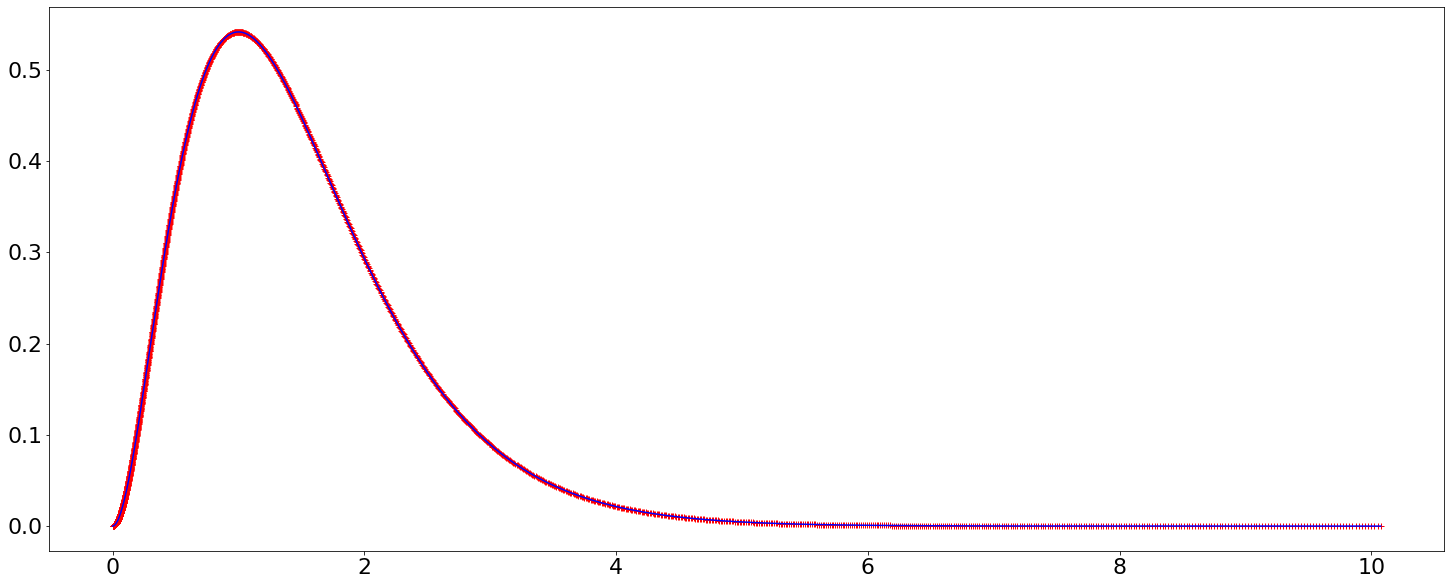

In [7]:
plt.plot(exp_grid,np.array(u_func_norm)**2,'r+', exp_grid,np.array(u_hydr_norm)**2,'b-')
plt.show()

In [13]:
#secant method
temp_nodes_posi= nodes_positions[0]
N_max=100
tolerance=1.0e-6
i=0


p0= temp_nodes_posi[0]
kwargs={'delta_x': 0.001, 'r_N':10.0, 'l':0, 'Z':1.0, 'E':p0}
u_func= predictor_corrector_radial_shcrodinger_integrator(r_grid_reversed, w10,w20, kwargs)
u_func= utils.normalize_u_function(u_func, kwargs['delta_x'])
q0= u_func[-1]

p1= temp_nodes_posi[1]
kwargs={'delta_x': 0.001, 'r_N':10.0, 'l':0, 'Z':1.0, 'E':p1}
u_func= predictor_corrector_radial_shcrodinger_integrator(r_grid_reversed, w10,w20, kwargs)
u_func= utils.normalize_u_function(u_func, kwargs['delta_x'])
q1= u_func[-1]

while i < N_max:
    p= p1 - q1*(p1-p0)/(q1-q0)
    if abs(p-p1) < tolerance:
        break
    p0=p1
    q0=q1
    p1=p
    kwargs={'delta_x': 0.001, 'r_N':10.0, 'l':0, 'Z':1.0, 'E':p1}
    u_func= predictor_corrector_radial_shcrodinger_integrator(r_grid_reversed, w10,w20, kwargs)
    u_func= utils.normalize_u_function(u_func, kwargs['delta_x'])
    q1= u_func[-1]
    i+=1
print(i)
kwargs={'delta_x': 0.001, 'r_N':10.0, 'l':0, 'Z':1.0, 'E':p}
u_func= predictor_corrector_radial_shcrodinger_integrator(r_grid_reversed, w10,w20, kwargs)
u_func= utils.normalize_u_function(u_func, kwargs['delta_x'])

3


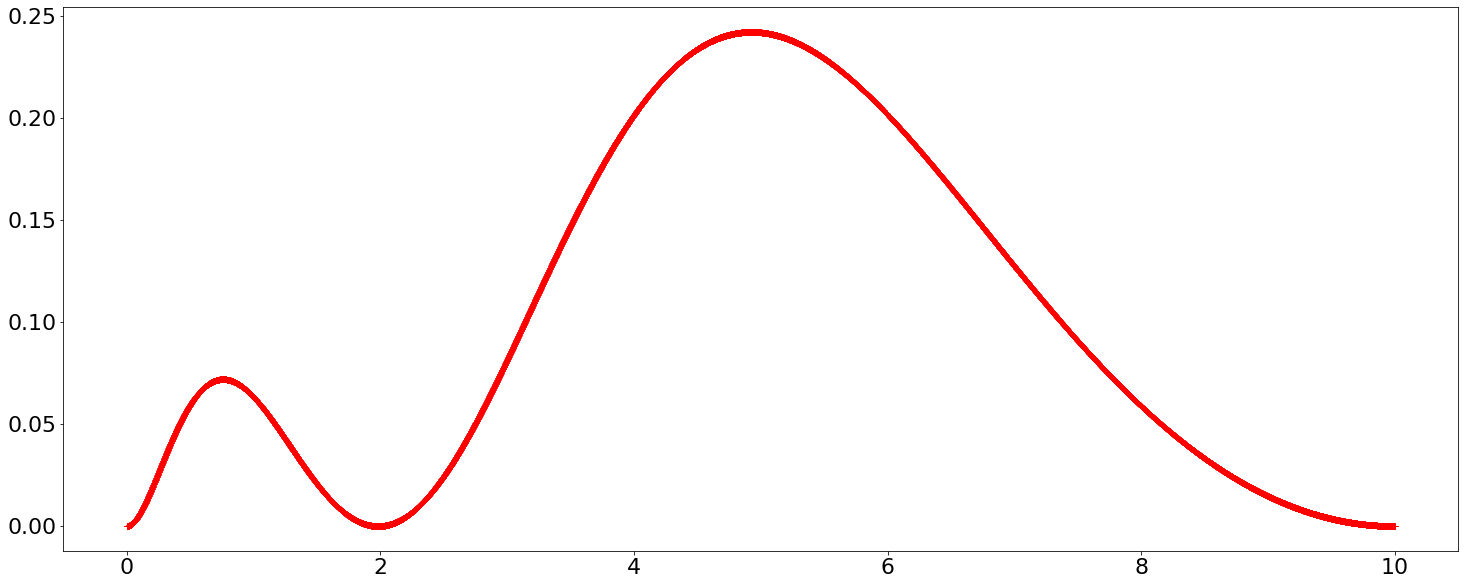

In [14]:
plt.plot(r_grid_reversed,np.array(u_func)**2,'r+')
plt.show()

In [17]:
u_func[-1]

7.056174246030256e-15

In [19]:
r_grid_reversed[-1]

1.0259154636926837e-13

In [16]:
r_grid_reversed[-1]

9.966808872359859e-12

In [19]:
u_func[-1]

1.9913800516305441e-10

In [20]:
u_func[0]

1.1714435248363741e-34

In [21]:
r_grid_reversed[0]

10.0

In [18]:
kwargs={'delta_x': 0.001, 'r_N':10.0, 'l':0, 'Z':1.0, 'E':-0.5}
u_func= predictor_corrector_radial_shcrodinger_integrator(r_grid_reversed, w10,w20, kwargs)
u_func= utils.normalize_u_function(u_func, kwargs['delta_x'])

In [9]:

u_hydr_normalized= utils.normalize_u_function(u_hydr, kwargs['delta_x'])

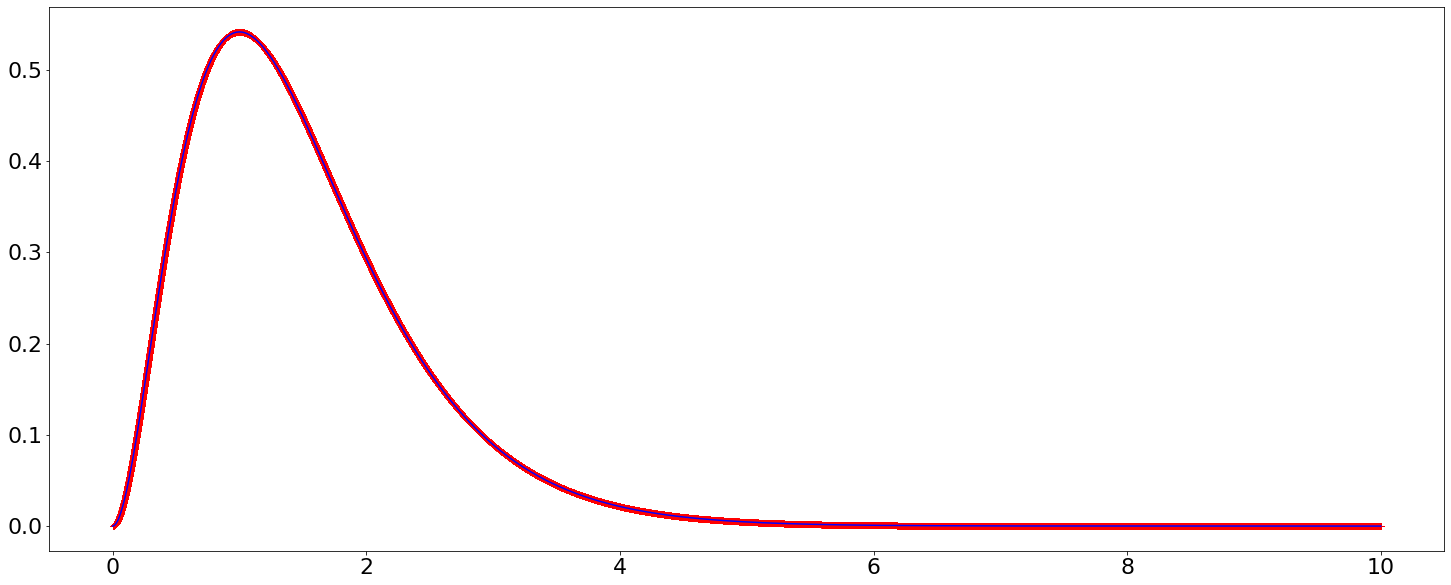

In [11]:
plt.plot(r_grid_reversed,np.array(u_func)**2,'r+', r_grid_reversed,u_hydr_normalized**2,'b-')
plt.show()

In [12]:
temp= np.abs(np.array(u_func)- u_hydr_normalized)

In [13]:
temp

array([9.07998640e-04, 9.08242635e-04, 9.08486638e-04, ...,
       8.00582647e-04, 4.00699798e-04, 7.36801628e-07])